In [125]:
#modules and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import yfinance
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

In [155]:
#importing the data
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", end = "2018-01-29", 
                              interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)
df_comp = raw_data.copy()

#defining columns
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

del df_comp['^N225'], df_comp['^GSPC'], df_comp['^GDAXI'], df_comp['^FTSE']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

#adding returns columns
df_comp['ret_spx'] = df_comp.spx.pct_change(1)*100
df_comp['ret_dax'] = df_comp.dax.pct_change(1)*100
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1)*100
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1)*100

#normalizing the returns columns
df_comp['nret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['nret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['nret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['nret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

#integrated prices columns
df_comp['delta_ftse'] = df_comp.ftse.diff(1)
df_comp['delta_spx'] = df_comp.spx.diff(1)
df_comp['delta_dax'] = df_comp.dax.diff(1)
df_comp['delta_nikkei'] = df_comp.nikkei.diff(1)

#split data
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

[*********************100%***********************]  4 of 4 completed


### Fitting the Model
Lets start with a simple example of modeling and forecasting using an AR(1) model. We are using the ARIMA module so we can make as few changes as possible if we need to expand into other ARMA/SARMA family models.

### Forecasting Prices 

In [156]:
#AR(1) model
model_ar = ARIMA(df.ftse, order=(1,0,0))
results_ar = model_ar.fit()

In [157]:
#Simple Forecast
start_date = '2013-04-08' #first business day of forecast period
end_date = '2015-01-01' #last day of foecast

In [158]:
data_pred_ar = results_ar.predict(start=start_date, end=end_date)

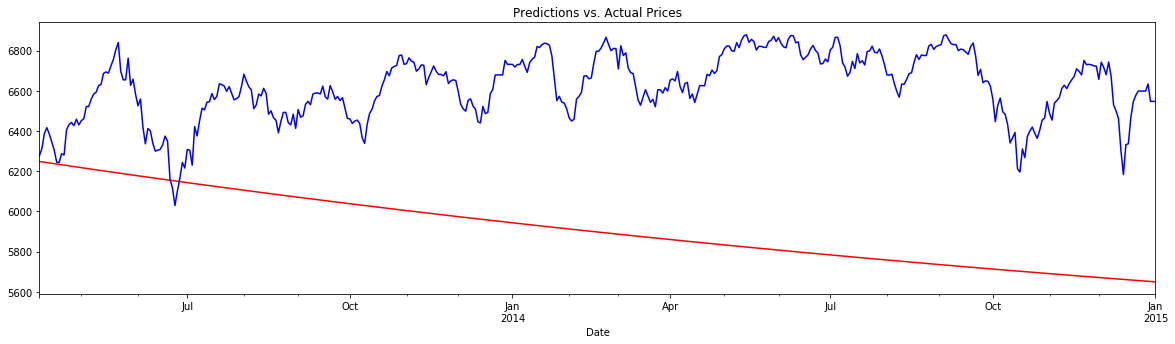

In [159]:
data_pred_ar[start_date:end_date].plot(figsize=(20,5), color='red')
#Compare predictions to actual values
df_test.ftse[start_date:end_date].plot(color='blue')
plt.title('Predictions vs. Actual Prices')
plt.show()

This model AR is using past values to predict the new values. Which is why they keep decreasing and this doesn't really make sense for predictions. It doesn't take into account the past errors, any seasonality, or exogenous variables. We can improve our model by adding more time varying components.

### Forecasting Returns - AR Model

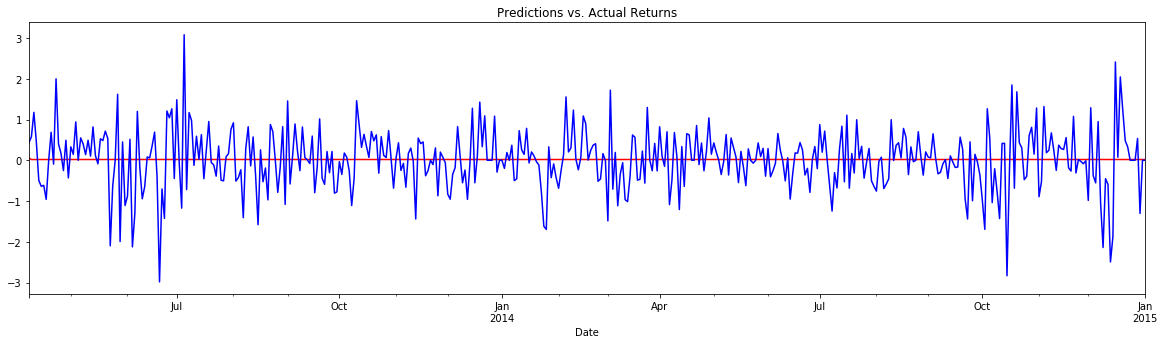

In [160]:
model_ar = ARIMA(df.ret_ftse[1:], order=(1,0,0))
results_ar = model_ar.fit()
data_pred_ar = results_ar.predict(start=start_date, end=end_date)
data_pred_ar[start_date:end_date].plot(figsize=(20,5), color='red')

#Compare predictions to actual values
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('Predictions vs. Actual Returns')
plt.show()

From above, we note that AR models are not good at predicting non-stationary data, and are somewhat better with stationary data but we do not capture everything

### Forecasting Returns - MA Model

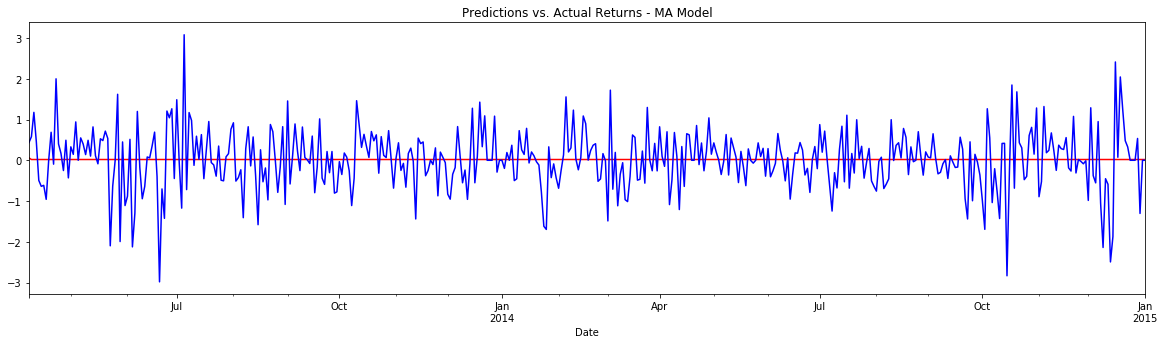

In [161]:
model_ma = ARIMA(df.ret_ftse[1:], order=(0,0,1))
results_ma = model_ma.fit()
data_pred_ma = results_ma.predict(start=start_date, end=end_date)
data_pred_ma[start_date:end_date].plot(figsize=(20,5), color='red')

#Compare predictions to actual values
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('Predictions vs. Actual Returns - MA Model')
plt.show()

In [107]:
data_pred_ma.head()

2013-04-08    0.059552
2013-04-09    0.018774
2013-04-10    0.018774
2013-04-11    0.018774
2013-04-12    0.018774
Freq: B, dtype: float64

All values after the first period dont change. Could be because:
- Error terms dont exist after the qth period
- MA terms are so small you are basically having a constant throughout for error

Let's try and see which reason it is by trying a higher order MA model

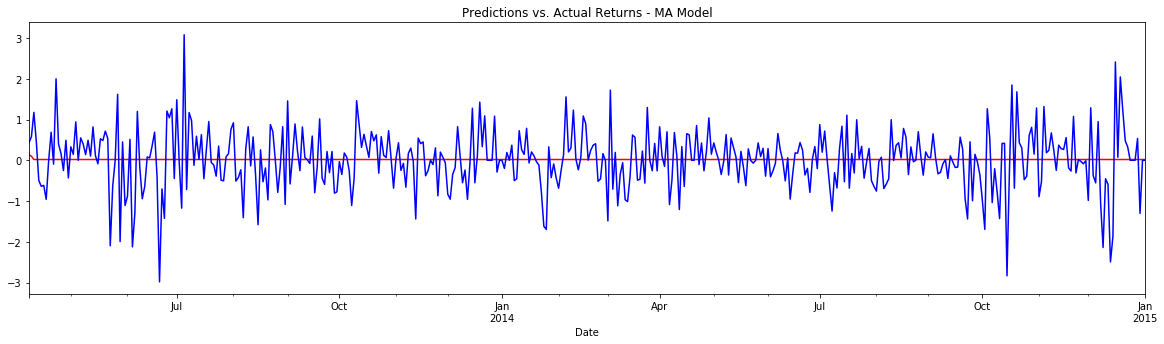

In [162]:
model_ma = ARIMA(df.ret_ftse[1:], order=(0,0,2))
results_ma = model_ma.fit()
data_pred_ma = results_ma.predict(start=start_date, end=end_date)
data_pred_ma[start_date:end_date].plot(figsize=(20,5), color='red')

#Compare predictions to actual values
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('Predictions vs. Actual Returns - MA Model')
plt.show()

In [109]:
data_pred_ma.head()

2013-04-08    0.132563
2013-04-09    0.100353
2013-04-10    0.018817
2013-04-11    0.018817
2013-04-12    0.018817
Freq: B, dtype: float64

After the 2nd (qth) prediction, the value stays the same similar to the MA(1) model. Therefore we see that after the qth prediction, we dont have error terms with the MA models so these are not the best either at forecasting returns. What if we try an ARMA model

### Forecasting Returns - (S)AR(I)MA(X) Model
Starting with **ARMA(1,1)**

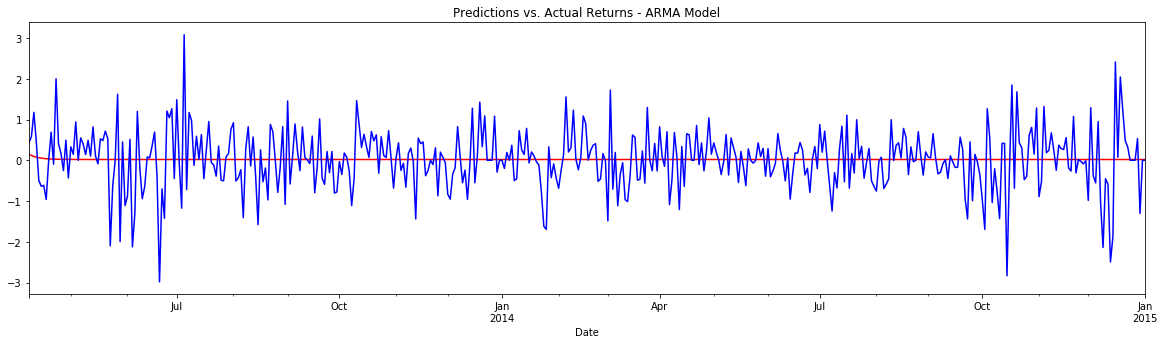

In [163]:
model_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_arma = model_arma.fit()
data_pred_arma = results_arma.predict(start=start_date, end=end_date)
data_pred_arma[start_date:end_date].plot(figsize=(20,5), color='red')

#Compare predictions to actual values
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('Predictions vs. Actual Returns - ARMA Model')
plt.show()

In [111]:
data_pred_arma.head()

2013-04-08    0.149100
2013-04-09    0.117960
2013-04-10    0.094269
2013-04-11    0.076244
2013-04-12    0.062530
Freq: B, dtype: float64

In [112]:
data_pred_arma.tail()

2014-12-26    0.018909
2014-12-29    0.018909
2014-12-30    0.018909
2014-12-31    0.018909
2015-01-01    0.018909
Freq: B, dtype: float64

Values are consistently decreasing like in the AR model, but much slowly. However, the last five values (Seen below) end our being a constant. Since the shift is down consistently, this doesn't make much sense as a predictive model for returns.

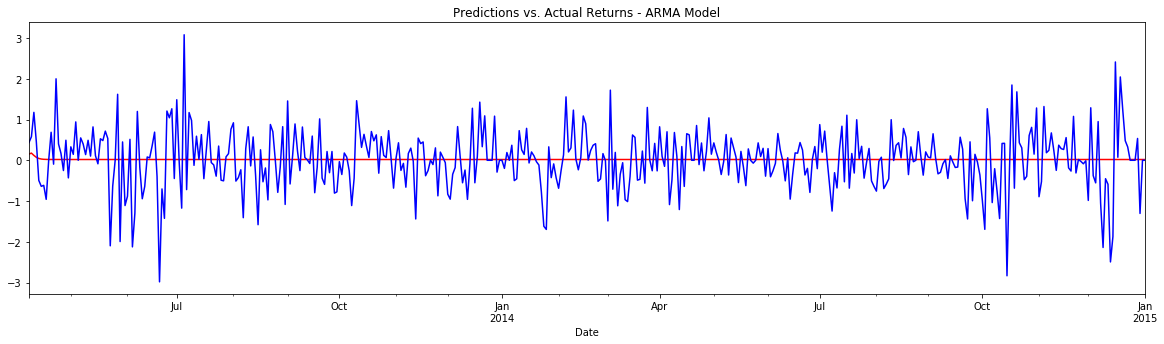

In [164]:
model_arma = ARIMA(df.ret_ftse[1:], order=(2,0,2))
results_arma = model_arma.fit()
data_pred_arma = results_arma.predict(start=start_date, end=end_date)
data_pred_arma[start_date:end_date].plot(figsize=(20,5), color='red')

#Compare predictions to actual values
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('Predictions vs. Actual Returns - ARMA Model')
plt.show()

In [114]:
data_pred_arma.head()

2013-04-08    0.152158
2013-04-09    0.175562
2013-04-10    0.119492
2013-04-11    0.072355
2013-04-12    0.044591
Freq: B, dtype: float64

In [115]:
data_pred_arma.tail()

2014-12-26    0.018909
2014-12-29    0.018909
2014-12-30    0.018909
2014-12-31    0.018909
2015-01-01    0.018909
Freq: B, dtype: float64

With higher order model, the values fluctuate ever so slightly, but they still end up going down and flattening out as seen above in the last values

### ARMAX Model

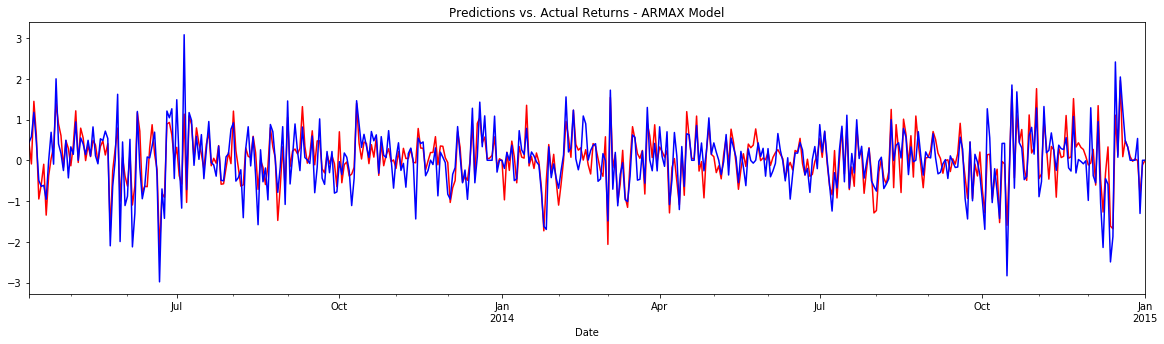

In [165]:
model_armax = ARIMA(df.ret_ftse[1:], exog = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], order=(1,0,1))
results_armax = model_armax.fit()
data_pred_armax = results_armax.predict(start=start_date, end=end_date,
                                      exog=df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])

data_pred_armax[start_date:end_date].plot(figsize=(20,5), color='red')

#Compare predictions to actual values
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('Predictions vs. Actual Returns - ARMAX Model')
plt.show()

Note above: In the ARMAX model, including exogenous variables allows model to have more predictive power because they have more information where as the ARMA cannot take in other factors along with past values and errors. ARMAX models improve our predictions drastically, but it can make forecasting impossible because we don't have the exogenous variables for the future so we cannot know how close our forecast is because we don't know how those other values changing may affect the forecasted values. I.e. we dont have a testing or validation set for the exogenous variables when using ARMAX models, whereas we do when using AR, MA, ARMA models. **This is why we make the distinction that predictions != forecasts. We say predictions when talking about in-sample estimations (you have a validation/testing set) and forecasts when talking about out-of-sample estimations**. SO we can make accurate predictions but poor forecasts with AR(I)MAX models

### Forecasting Prices = ARIMA Model

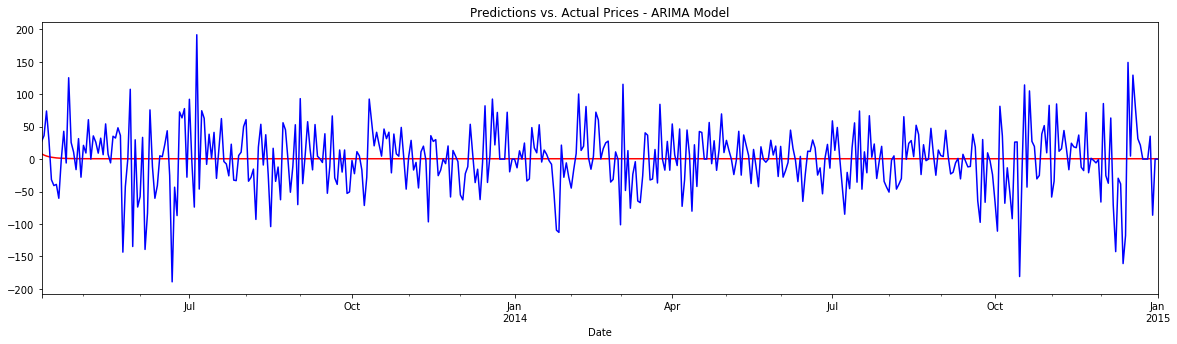

In [166]:
#ARIMA Model
model_arima = ARIMA(df.ftse, order=(1,1,1))
results_arima = model_arima.fit()
data_pred_arima = results_arima.predict(start=start_date, end=end_date)

data_pred_arima[start_date:end_date].plot(figsize=(20,5), color='red')

#Compare predictions to actual values
df_test.delta_ftse[start_date:end_date].plot(color='blue')
plt.title('Predictions vs. Actual Prices - ARIMA Model')
plt.show()

In [118]:
data_pred_arima.head()

2013-04-08    8.132366
2013-04-09    6.197812
2013-04-10    4.757840
2013-04-11    3.686007
2013-04-12    2.888196
Freq: B, dtype: float64

In [119]:
data_pred_arima.tail()

2014-12-26    0.565378
2014-12-29    0.565378
2014-12-30    0.565378
2014-12-31    0.565378
2015-01-01    0.565378
Freq: B, dtype: float64

### Forecasting Prices = ARIMAX Model

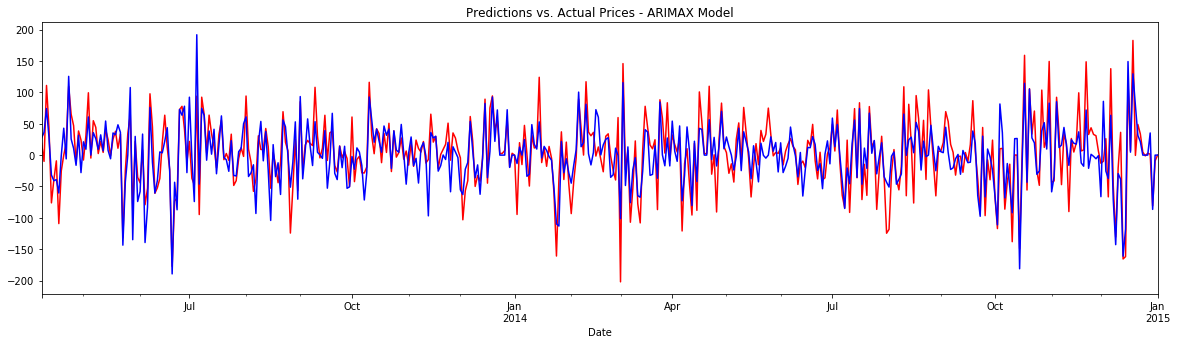

In [167]:
model_arimax = ARIMA(df.delta_ftse[1:], exog = df[['delta_spx', 'delta_dax', 'delta_nikkei']][1:], order=(1,0,1))
results_arimax = model_arimax.fit()
data_pred_arimax = results_arimax.predict(start=start_date, end=end_date,
                                      exog=df_test[['delta_spx', 'delta_dax', 'delta_nikkei']][start_date:end_date])

data_pred_arimax[start_date:end_date].plot(figsize=(20,5), color='red')

#Compare predictions to actual values
df_test.delta_ftse[start_date:end_date].plot(color='blue')
plt.title('Predictions vs. Actual Prices - ARIMAX Model')
plt.show()

ARIMA and ARIMAX models behave the same as the ARMA and ARMAX models

### Forecasting Returns - SARMA Model

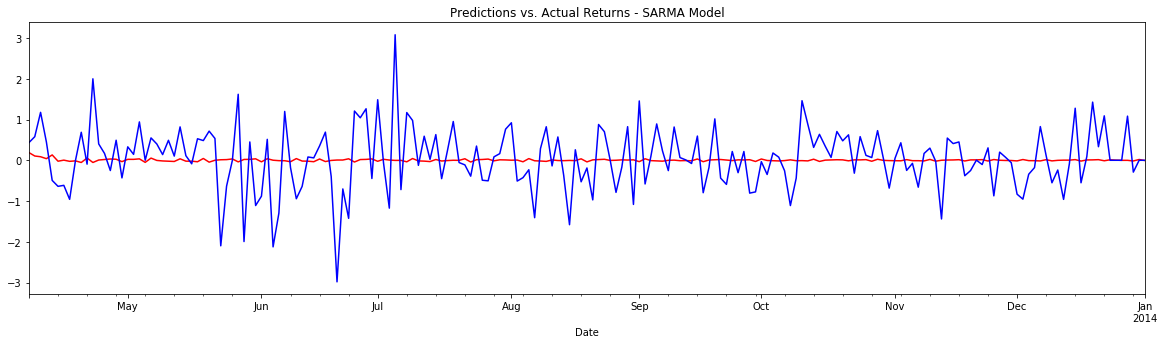

In [168]:
end_date = '2014-01-01'
model_sarma = SARIMAX(df.ret_ftse[1:], order=(3,0,4), seasonal_order=(3,0,2,5))
results_sarma = model_sarma.fit()
data_pred_sarma = results_sarma.predict(start = start_date, end = end_date)

data_pred_sarma[start_date:end_date].plot(figsize=(20,5), color='red')

#Compare predictions to actual values
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('Predictions vs. Actual Returns - SARMA Model')
plt.show()

### Forecasting Prices - SARIMAX Model

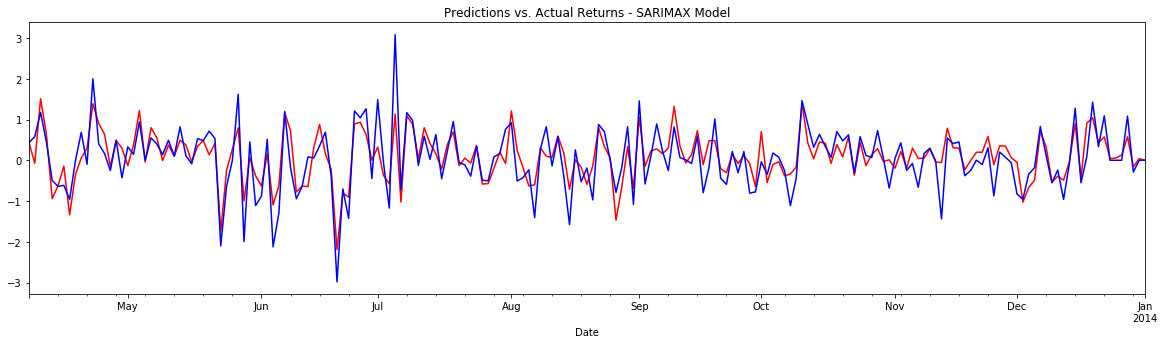

In [169]:
model_sarimax = SARIMAX(df.ret_ftse[1:], exog = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], order=(3,0,4), seasonal_order=(3,0,2,5))
results_sarimax = model_sarimax.fit()
data_pred_sarimax = results_sarimax.predict(start=start_date, end=end_date,
                                      exog=df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])

data_pred_sarimax[start_date:end_date].plot(figsize=(20,5), color='red')

#Compare predictions to actual values
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('Predictions vs. Actual Returns - SARIMAX Model')
plt.show()

Again the SARMA and SARIMAX follow the trend set by the ARMA and ARMAX and followed by ARIMA and ARIMAX. Now to the auto arima method

### Auto ARIMA

In [133]:
model_auto = auto_arima(df.ret_ftse[1:], exogenous = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [139]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

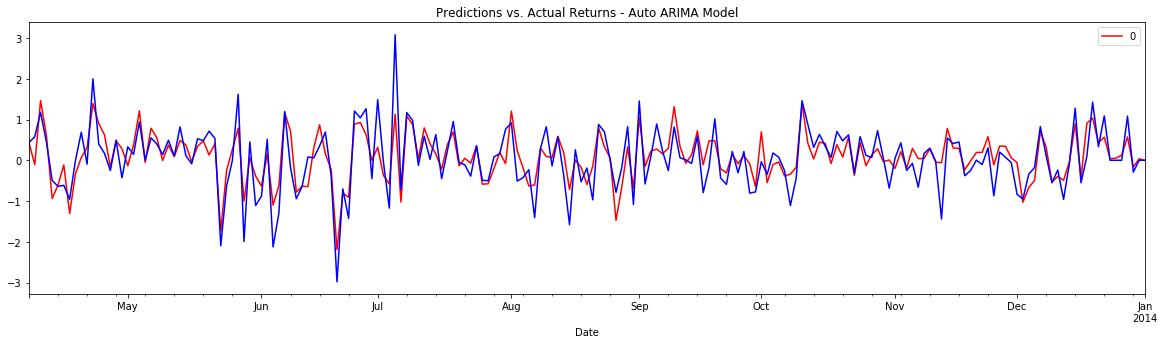

In [140]:
df_auto_pred[start_date:end_date].plot(figsize=(20,5), color='red')

#Compare predictions to actual values
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('Predictions vs. Actual Returns - Auto ARIMA Model')
plt.show()

Note again, when given the SARIMA model option, the auto ARIMA method picks these models because they give the best predictions. However, we wouldnt get the best forecasts because we dont have values for future exogenous variables. In general, forecasting has some faults so depending on the data. We can compare the models as follows:

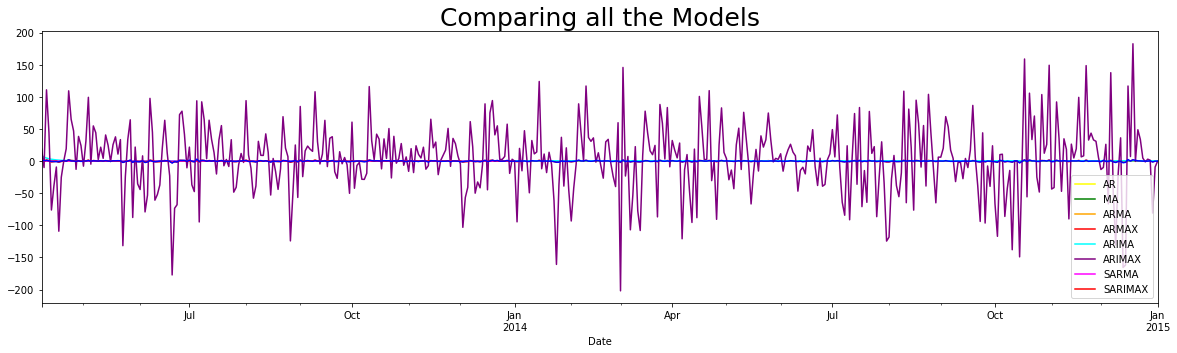

In [170]:
end_date = '2015-01-01'
data_pred_ar[start_date:end_date].plot(figsize=(20,5), color='yellow')
data_pred_ma[start_date:end_date].plot(figsize=(20,5), color='green')
data_pred_arma[start_date:end_date].plot(figsize=(20,5), color='orange')
data_pred_armax[start_date:end_date].plot(figsize=(20,5), color='red')
data_pred_arima[start_date:end_date].plot(figsize=(20,5), color='cyan')
data_pred_arimax[start_date:end_date].plot(figsize=(20,5), color='purple')
data_pred_sarma[start_date:end_date].plot(figsize=(20,5), color='magenta')
data_pred_sarimax[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_ftse[start_date:end_date].plot(figsize=(20,5), color='blue')
plt.legend(['AR', 'MA', 'ARMA', 'ARMAX', 'ARIMA', 'ARIMAX', 'SARMA', 'SARIMAX'])
plt.title('Comparing all the Models', size=25)
plt.show()

### Forecasting Peculiarities
- Not good with non-stationary data
- Note that because the AR, MA, ARMA curves almost flatten out and are similar to ARMAX, the last line ploted appears above the others so we cannot even see them
- Integrated data forecasts cannot be compared to prices so you have to compare to differenced prices
- AR only depends on past values and the autocorrelation dies out slowly
- MA only depends on error terms so we cannot autogenerate future residuals so we can't use it to forecast many periods ahead. ONE WAY to fix this is to manually predict white noise
- ARMA is a combination of the above two so even if we make artificial white noise, we still have issues with AR portion
- Any models with exogenous variables, we make good predictions but we wont be able to forecast ahead because we dont have the future values for the exogenous variable time series

**We have to find a meaningful way to forecast this data. Prices and returns have both presented issues so we will move forward and try to forecast volatility**

### Forecasting Volatility - ARCH Model
In the forecast method of arch model package:
- horizon = how many observations we want our model to predict for each date i.e. h = 1 means for each day, give the forecast for just the next day
- align = determines whether we match the predi)cted value with the date the prediction is made on (origin, or the one it's supposed to represent (target). We prefer the one its supposed to represent so thats what we use

In [171]:
#model with entire dataset
model_garch = arch_model(df_comp.ret_ftse[1:], vol = 'GARCH', p = 1, q =1, mean='constant', dist= 'Normal')
results_garch = model_garch.fit(last_obs= start_date, update_freq=10)

Iteration:     10,   Func. Count:     73,   Neg. LLF: 6970.583234684342
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6970.54757560693
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13


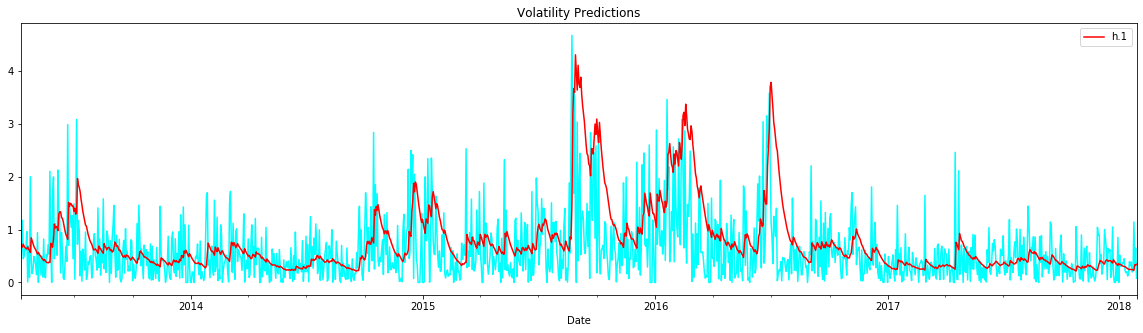

In [176]:
pred_garch = results_garch.forecast(horizon = 1, align= 'target')
pred_garch.residual_variance[start_date:].plot(figsize=(20,5), color='red', zorder = 2)
df_test.ret_ftse.abs().plot(color = 'cyan', zorder = 1)
plt.title('Volatility Predictions')
plt.show()

Above we see that volatility is forecasted better than returns as the conditional variances of past periods are considered and we forecast one day ahead for each day we can predict volatility for. This approach allows us to get around the issue of not having future exogenous variable values to use (since we established these are the best modelsfor prediction). There is another way to go around this. We can also predict the future exogenous variable values and use those to forecast our variable time series of interest through **multivariate forecasting**.


### Multiple Regression Forecasting
With Simple AR model. Since each model is a vector, they are each called Vector models i.e. VAR, VMA, VARMA etc because each component is a vector containing the fitted values for each time series component when you are regressiong multiple time series at the same time. So in the component for VAR(t-1) = [var(ftse), var(spx), var(dax), var(nikkei)]

### Simple Vector AR (VAR) Model

In [178]:
from statsmodels.tsa.api import VAR

In [179]:
df_ret = df[['ret_spx', 'ret_ftse', 'ret_dax', 'ret_nikkei']][1:]
#model
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20) #maximum order of the model (# of lags x # of time series)
results_var_ret = model_var_ret.fit(ic='aic')

In [180]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 14, Apr, 2020
Time:                     22:46:55
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.452001
Nobs:                     5015.00    HQIC:                  0.381061
Log likelihood:          -29239.5    FPE:                    1.40887
AIC:                     0.342790    Det(Omega_mle):         1.38552
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.035673         0.017036            2.094           0.036
L1.ret_spx           -0.112245         0.018135           -6.189           0.000
L1.ret_ftse          -0.011926         0.025268           

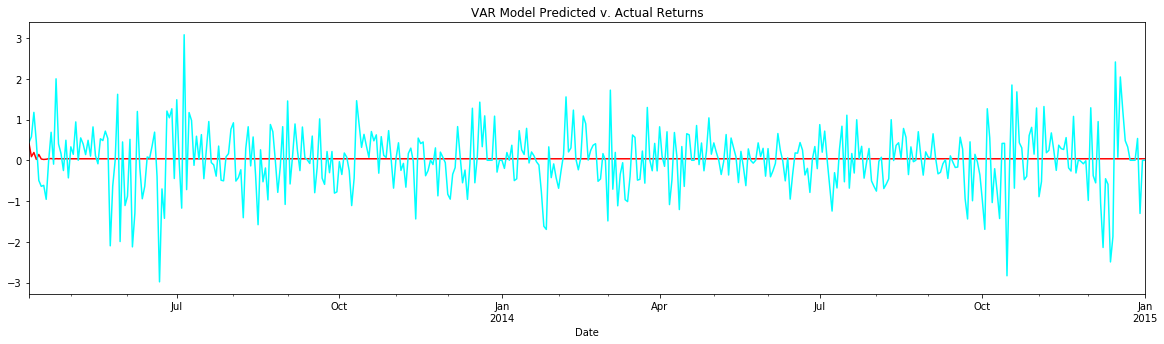

In [182]:
lag_order_ret = results_var_ret.k_ar #number of lags
var_pred_ret =results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))

#get predicted values and label columns based on return values
df_ret_pred = pd.DataFrame(data=var_pred_ret, index = df_test[start_date:end_date].index,
                          columns = df_test[start_date:end_date].columns[4:8])

#plot against actual values
df_ret_pred.ret_ftse[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_ftse[start_date:end_date].plot(color='cyan')
plt.title('VAR Model Predicted v. Actual Returns')
plt.show()

This still looks like an AR model because we are still not including today's exogenous values in our model (we dont have them) only past ones. We can use VAR specific plot forecast method to predict values ahead for each of the time series modeled and see what we can expect if we use the predictions for the exogenous series to forecast.

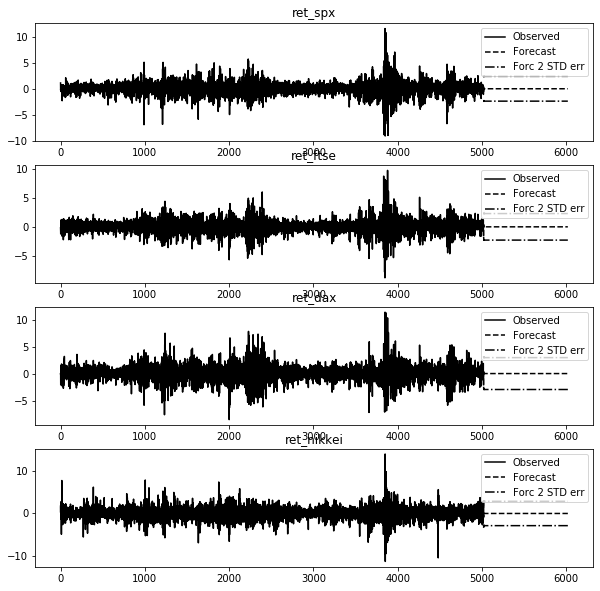

In [183]:
results_var_ret.plot_forecast(1000) #method to get 1000 forecasts for every market index
plt.show()